# Evaluation
This notebook presents evalulation results of final models on different test sets

In [33]:
import os
import sys
import argparse
import traceback


import logging
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from itertools import combinations, permutations

import cmbnet.utils.utils_plotting as utils_plotting
import ast

In [34]:
eval_dir = "../../data-misc/evaluations"
l1_dirs = ['Scratch-Pretrained-FineTuned', 'TL-Pretrained-FineTuned']
l2_dirs = ['predict_cmb_valid', 'predict_cmb_dou', 'predict_cmb_crb']
l3_dirs = ['valloss', 'F1macro']

classification_fname = "classification_metrics.csv"
detection_metrics_fname = "detection_metrics.csv"
segmentation_metrics_fname = "segmentation_metrics.csv"

study_results_det_fname = 'study_results_detection.pkl'
study_results_seg_fname = 'study_results_segmentation.pkl'

cmb_results_det_fname = 'all_cmbs_tracking.pkl'

In [48]:
gt_radiomics_metadata_csv = (
    "/storage/evo1/jorge/MicrobleedNet/data-misc/csv/CMB_radiomics_metadata.csv"
)
gt_cmb_metadata_csv = (
    "/storage/evo1/jorge/MicrobleedNet/data-misc/csv/CMB_metadata_all.csv"
)
all_studies_csv = "/storage/evo1/jorge/MicrobleedNet/data-misc/csv/ALL_studies.csv"

all_studies_df = pd.read_csv(all_studies_csv)
GT_metadata = pd.read_csv(gt_cmb_metadata_csv)
GT_metadata_radiomics = pd.read_csv(gt_radiomics_metadata_csv)

# Convert string representations of tuples to actual tuples
GT_metadata["CM"] = GT_metadata["CM"].apply(lambda x: tuple(ast.literal_eval(x)))
GT_metadata_radiomics["CM"] = GT_metadata_radiomics["CM"].apply(
    lambda x: tuple(ast.literal_eval(x))
)

GT_metadata_all = pd.merge(
    GT_metadata, GT_metadata_radiomics, on=["seriesUID", "CM"], how="inner"
).drop(
    columns=[
        "firstorder_10Percentile",
        "firstorder_90Percentile",
        "firstorder_Energy",
        "firstorder_Entropy",
        "firstorder_InterquartileRange",
        "firstorder_Kurtosis",
        "firstorder_Maximum",
        "firstorder_MeanAbsoluteDeviation",
        "firstorder_Mean",
        "firstorder_Median",
        "firstorder_Minimum",
        "firstorder_Range",
        "firstorder_RobustMeanAbsoluteDeviation",
        "firstorder_RootMeanSquared",
        "firstorder_Skewness",
        "firstorder_TotalEnergy",
        "firstorder_Uniformity",
        "firstorder_Variance",
    ]
)

/tmp/ipykernel_3646435/3961993545.py:10: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  GT_metadata = pd.read_csv(gt_cmb_metadata_csv)


In [35]:
classification_data = []
detection_data = []
segmentation_data = []

# Loop through models, criteria, and then datasets
for l1 in l1_dirs:
    for l3 in l3_dirs:
        for l2 in l2_dirs:
            dataset = l2.split('_')[-1]  # Extract the dataset name from l2
            base_path = os.path.join(eval_dir, l1, l2, l3)
            class_path = os.path.join(base_path, classification_fname)
            detect_path = os.path.join(base_path, detection_metrics_fname)
            seg_path = os.path.join(base_path, segmentation_metrics_fname)

            # Load classification metrics if available
            if os.path.exists(class_path):
                df_class = pd.read_csv(class_path)
                df_class['Model'] = l1
                df_class['Criteria'] = l3
                df_class['Dataset'] = dataset

                classification_data.append(df_class)

            # Load detection metrics if available
            if os.path.exists(detect_path):
                df_detect = pd.read_csv(detect_path)
                df_detect['Model'] = l1
                df_detect['Criteria'] = l3
                df_detect['Dataset'] = dataset

                detection_data.append(df_detect)

            # Load segmentation metrics if available
            if os.path.exists(seg_path):
                df_seg = pd.read_csv(seg_path)
                df_seg['Model'] = l1
                df_seg['Criteria'] = l3
                df_seg['Dataset'] = dataset

                segmentation_data.append(df_seg)

# Concatenate data into separate dataframes for each metric type
df_classification = pd.concat(classification_data, ignore_index=True)
df_detection = pd.concat(detection_data, ignore_index=True)
df_segmentation = pd.concat(segmentation_data, ignore_index=True)

# move columns Model, Criteria and Dataste in front
cols = df_classification.columns.tolist()
cols = cols[-3:] + cols[:-3]
df_classification = df_classification[cols]

cols = df_detection.columns.tolist()
cols = cols[-3:] + cols[:-3]
df_detection = df_detection[cols]

cols = df_segmentation.columns.tolist()
cols = cols[-3:] + cols[:-3]
df_segmentation = df_segmentation[cols]

In [36]:
# Dictionaries to store detailed study data
detection_details = {}
segmentation_details = {}
cmb_results = {}

for l1 in l1_dirs:
    for l2 in l2_dirs:
        dataset = l2.split('_')[-1]  # Extract dataset name from l2
        for l3 in l3_dirs:
            base_path = os.path.join(eval_dir, l1, l2, l3)
            # File paths
            class_path = os.path.join(base_path, classification_fname)
            detect_path = os.path.join(base_path, detection_metrics_fname)
            seg_path = os.path.join(base_path, segmentation_metrics_fname)
            detect_study_path = os.path.join(base_path, study_results_det_fname)
            seg_study_path = os.path.join(base_path, study_results_seg_fname)
            cmb_results_path = os.path.join(base_path, cmb_results_det_fname)
            
            # Load study result details if available
            if os.path.exists(detect_study_path):
                with open(detect_study_path, 'rb') as file:
                    detection_details[(l1, dataset, l3)] = pickle.load(file)
            if os.path.exists(seg_study_path):
                with open(seg_study_path, 'rb') as file:
                    segmentation_details[(l1, dataset, l3)] = pickle.load(file)
            if os.path.exists(cmb_results_path):
                with open(cmb_results_path, 'rb') as file:
                    cmb_results[(l1, dataset, l3)] = pickle.load(file)

In [37]:
cmb_results

{('Scratch-Pretrained-FineTuned',
  'valid',
  'valloss'): [{'seriesUID': 'RODEJA-00001-CMB-2',
   'CM': (75, 226, 190),
   'call': 'FN',
   'type': 'GT',
   'matched_CM': None}, {'seriesUID': 'RODEJA-00001-CMB-2',
   'CM': (219, 205, 143),
   'call': 'FN',
   'type': 'GT',
   'matched_CM': None}, {'seriesUID': 'RODEJA-00008-CMB-1',
   'CM': (179, 110, 241),
   'call': 'FP',
   'type': 'pred',
   'matched_CM': None}, {'seriesUID': 'RODEJA-00008-CMB-1',
   'CM': (212, 247, 212),
   'call': 'TP',
   'type': 'pred',
   'matched_CM': (212, 247, 211)}, {'seriesUID': 'RODEJA-00008-CMB-1',
   'CM': (212, 247, 211),
   'call': 'TP',
   'type': 'GT',
   'matched_CM': (212, 247, 212)}, {'seriesUID': 'RODEJA-00051-CMB-3',
   'CM': (223, 58, 95),
   'call': 'TP',
   'type': 'pred',
   'matched_CM': (223, 58, 95)}, {'seriesUID': 'RODEJA-00051-CMB-3',
   'CM': (223, 58, 95),
   'call': 'TP',
   'type': 'GT',
   'matched_CM': (223, 58, 95)}, {'seriesUID': 'RODEJA-00051-CMB-3',
   'CM': (232, 124, 153

## Detection results

In [38]:
# TODO: select which to show

dataset = ["dou", "crb"]
model = ["Scratch-Pretrained-FineTuned"]
# criteria = ["F1macro", "valloss"]
criteria = ["F1macro"]
typemetric = "Micro"
df = df_detection

selected = df[(df['Dataset'].isin(dataset)) & (df['Model'].isin(model)) & (df['Criteria'].isin(criteria))]
selected = selected[selected['Metric'].str.contains(typemetric)]
selected

,Model,Criteria,Dataset,Metric,Mean,Std.
40,Scratch-Pretrained-FineTuned,F1macro,dou,Micro - Precision,0.886364,NaN
41,Scratch-Pretrained-FineTuned,F1macro,dou,Micro - Recall,0.527027,NaN
42,Scratch-Pretrained-FineTuned,F1macro,dou,Micro - F1,0.661017,NaN
43,Scratch-Pretrained-FineTuned,F1macro,dou,Micro - FPavg,0.024272,NaN
44,Scratch-Pretrained-FineTuned,F1macro,dou,Micro - FPcmb,0.005225,NaN
50,Scratch-Pretrained-FineTuned,F1macro,crb,Micro - Precision,0.709091,NaN
51,Scratch-Pretrained-FineTuned,F1macro,crb,Micro - Recall,0.307087,NaN
52,Scratch-Pretrained-FineTuned,F1macro,crb,Micro - F1,0.428571,NaN
53,Scratch-Pretrained-FineTuned,F1macro,crb,Micro - FPavg,0.077670,NaN
54,Scratch-Pretrained-FineTuned,F1macro,crb,Micro - FPcmb,0.016719,NaN


In [39]:
import pandas as pd

# Sample DataFrame (You should replace this with your actual DataFrame loading code)
# df = pd.read_csv('your_file.csv')

# Define filters
datasets = ["dou", "crb", "valid"]
models = ["Scratch-Pretrained-FineTuned", "TL-Pretrained-FineTuned"]
criterias = ["F1macro", "valloss"]
type_metric = "Macro - F1"

# Initialize an empty string to build the output
output = ""

# Ensure your DataFrame columns 'Mean' and 'Std.' exist and contain numerical data
for model in models:
    output += f"{model} -----------------------\n\n"
    for criteria in criterias:
        output += f"Selected with {criteria} .... \n"
        for dataset in datasets:
            # Filter the DataFrame
            selected = df[(df['Dataset'] == dataset) & (df['Model'] == model) & (df['Criteria'] == criteria)]
            selected = selected[selected['Metric'].str.contains(type_metric)]
            
            # Check if there is any data after filtering
            if not selected.empty:
                # Format mean and standard deviation as strings, concatenate with LaTeX formatting
                values = ', '.join(
                    selected['Metric'].astype(str).str.replace(" ", "") + ": " + 
                    selected['Mean'].round(4).astype(str) + " ± " + 
                    selected['Std.'].round(2).astype(str)
                )
            else:
                values = "No data available"
            
            # Append the results to the output string
            output += f"{dataset.upper()}: {values}\n"
        output += "\n"  # Add a newline for better separation between criteria

# Print the output
print(output)


Scratch-Pretrained-FineTuned -----------------------

Selected with F1macro .... 
DOU: Macro-F1: 0.7772 ± 0.24
CRB: Macro-F1: 0.4453 ± 0.22
VALID: Macro-F1: 0.789 ± 0.2

Selected with valloss .... 
DOU: Macro-F1: 0.8637 ± 0.18
CRB: Macro-F1: 0.4187 ± 0.19
VALID: Macro-F1: 0.775 ± 0.2

TL-Pretrained-FineTuned -----------------------

Selected with F1macro .... 
DOU: Macro-F1: 0.7986 ± 0.18
CRB: Macro-F1: 0.472 ± 0.25
VALID: Macro-F1: 0.7299 ± 0.21

Selected with valloss .... 
DOU: Macro-F1: 0.7986 ± 0.18
CRB: Macro-F1: 0.472 ± 0.25
VALID: Macro-F1: 0.7299 ± 0.21




/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

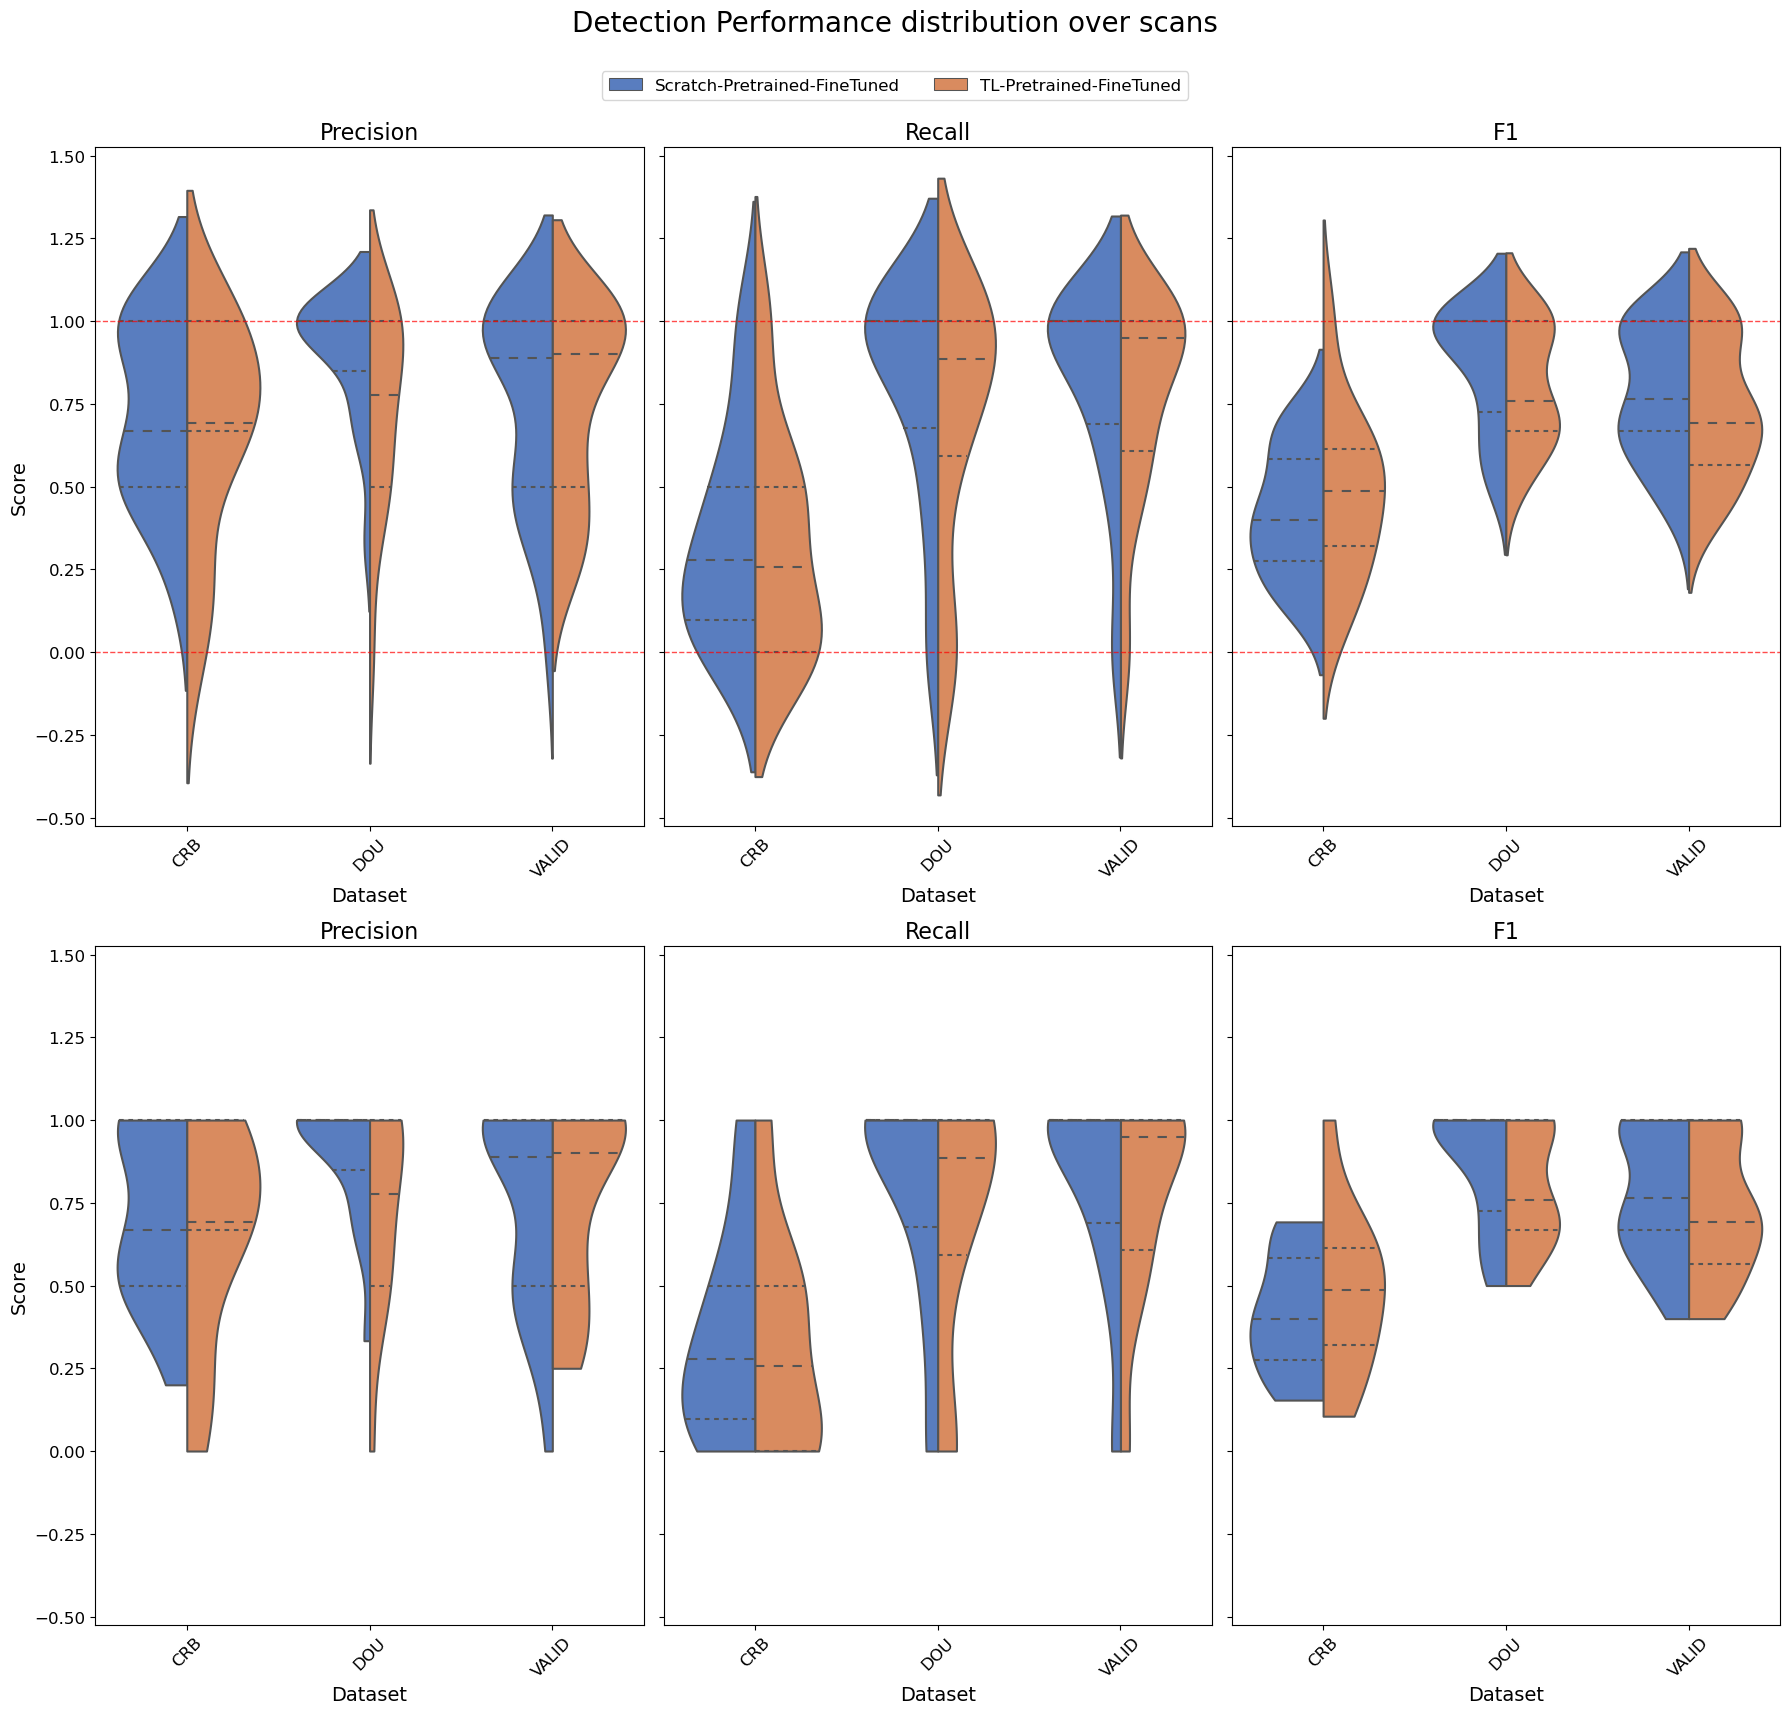

In [40]:
# Definitions
datasets = ["crb", "dou", "valid"]
models = ["Scratch-Pretrained-FineTuned", "TL-Pretrained-FineTuned"]
criteria = ["valloss"]
metrics = ["Precision", "Recall", "F1"]

# Setup figure and axes
fig, axs = plt.subplots(2, len(metrics), figsize=(18, 18), sharey=True)
fig.suptitle("Detection Performance distribution over scans", fontsize=20)

# Iterate over metrics to create a plot for each
for j, metric in enumerate(metrics):
    data_comb = pd.DataFrame()
    for model in models:
        for dataset in datasets:
            if (model, dataset, criteria[0]) in detection_details:
                detection_details_comb = detection_details[(model, dataset, criteria[0])]
                model_data = pd.DataFrame({
                    "Value": [s[metric] for s in detection_details_comb],
                    "Dataset": [dataset.upper()] * len(detection_details_comb),
                    "Model": [model] * len(detection_details_comb)
                })
                data_comb = pd.concat([data_comb, model_data], ignore_index=True)

    if not data_comb.empty:
        utils_plotting.create_violin_plot(
            ax=axs[0, j],
            data=data_comb.sort_values('Dataset'),
            column='Value',
            group_by='Dataset',
            title=f'{metric.capitalize()}',
            xlabel='Dataset',
            ylabel='Score' if j == 0 else "",
            hue = 'Model',
            split = True,
            rotation=45,
            fontsize_title=16,
            fontsize_labels=14,
            fontsize_ticks=12,
            palette="muted",
            cut=2,  
            showfliers=True,
            showmeans=False,  # Optionally display the means
            inner="quartile",  # Show quartiles within the violin
            y_lim=None,

        )
        # Drawing horizontal lines at y=0 and y=1
        axs[0, j].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)  # Line at y=0
        axs[0, j].axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.7)  # Line at y=1

        # Remove the legend from all except the last plot
        axs[0, j].get_legend().remove()

        utils_plotting.create_violin_plot(
            ax=axs[1, j],
            data=data_comb.sort_values('Dataset'),
            column='Value',
            group_by='Dataset',
            title=f'{metric.capitalize()}',
            xlabel='Dataset',
            ylabel='Score' if j == 0 else "",
            hue = 'Model',
            split = True,
            rotation=45,
            fontsize_title=16,
            fontsize_labels=14,
            fontsize_ticks=12,
            palette="muted",
            cut=0,  
            showfliers=True,
            showmeans=False,  # Optionally display the means
            inner="quartile",  # Show quartiles within the violin
            y_lim=None,

        )
        # Remove the legend from all except the last plot
        axs[1, j].get_legend().remove()


# Add a single unified legend for the whole figure
handles, labels = axs[1, j].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(models), fontsize=12, bbox_to_anchor=(0.5, 0.95))

# Adjust layout to accommodate the title and legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../../data-misc/img/final_scores_dataset_model.png")
plt.show()


/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

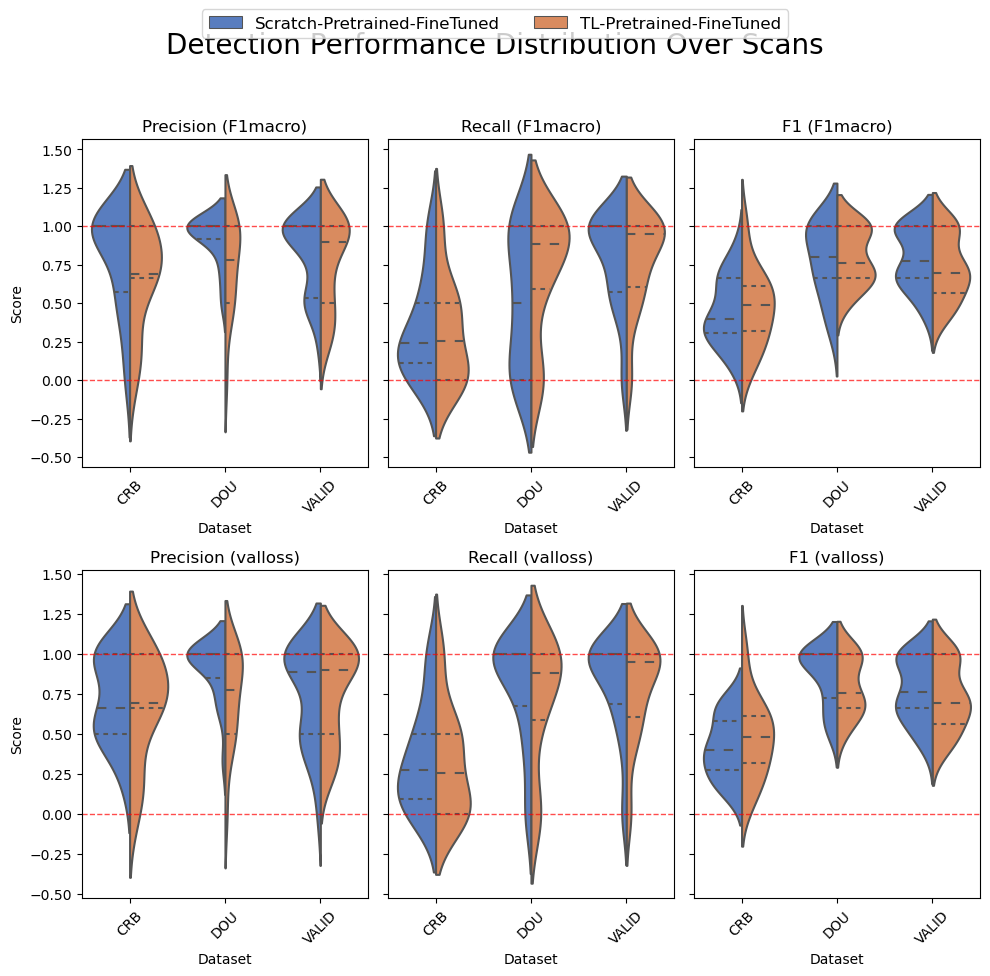

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming detection_details is a dictionary with keys (model, dataset, criteria)
# Example data structure needed for this script to work correctly

# Definitions
datasets = ["crb", "dou", "valid"]
models = ["Scratch-Pretrained-FineTuned", "TL-Pretrained-FineTuned"]
criteria = ["F1macro", "valloss"]
metrics = ["Precision", "Recall", "F1"]

# Setup figure and axes
fig, axs = plt.subplots(len(criteria), len(metrics), figsize=(10, 10), sharey='row')  # Adjusted to share y-axis by row
fig.suptitle("Detection Performance Distribution Over Scans", fontsize=20)


data_detection_all_df = pd.DataFrame()

# Iterate over each criterion and metric to create a plot for each combination
for i, crit in enumerate(criteria):
    for j, metric in enumerate(metrics):
        data_comb = pd.DataFrame()
        for model in models:
            for dataset in datasets:
                key = (model, dataset, crit)
                if key in detection_details:
                    detection_details_comb = detection_details[key]
                    model_data = pd.DataFrame({
                        "Criteria": [crit] * len(detection_details_comb),
                        "Metric": [metric]  * len(detection_details_comb),
                        "Value": [s[metric] for s in detection_details_comb],
                        "Dataset": [dataset.upper()] * len(detection_details_comb),
                        "Model": [model] * len(detection_details_comb)
                    })
                    data_comb = pd.concat([data_comb, model_data], ignore_index=True)
        data_detection_all_df = pd.concat([data_detection_all_df, data_comb], ignore_index=True)
        if not data_comb.empty:
            sns.violinplot(
                ax=axs[i, j],  # Adjusted axis indexing to handle rows and columns
                data=data_comb,
                x='Dataset',
                y='Value',
                hue='Model',
                split=True,
                inner="quartile",
                palette="muted"
            )
            axs[i, j].set_title(f'{metric.capitalize()} ({crit})')  # Show metric and criteria
            axs[i, j].set_xlabel('Dataset')
            axs[i, j].set_ylabel('Score' if j == 0 else "")
            axs[i, j].tick_params(axis="x", rotation=45)
            axs[i, j].tick_params(axis="y")
            axs[i, j].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
            axs[i, j].axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.7)
            
            # Remove the legend from all
            axs[i, j].get_legend().remove()

# Add a single unified legend for the whole figure
handles, labels = axs[-1, -1].get_legend_handles_labels()  # Grab handles and labels from the last plot
fig.legend(handles, labels, loc='upper center', ncol=len(models), fontsize=12, bbox_to_anchor=(0.5, 1.01))

# Adjust layout to accommodate the title and legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Load data series level

In [50]:
l1_dirs = ["Scratch-Pretrained-FineTuned", "TL-Pretrained-FineTuned"]
l2_dirs = ["predict_cmb_valid", "predict_cmb_dou", "predict_cmb_crb"]
l3_dirs = ["valloss"]
l4_dirs = [
    "Cerebellum",
    "Thalamus",
    "Basalgangliagreymatter",
    "Brainstem",
    "Subcorticalwhitematter",
    "CortexORgrey-whitejunction",
]
l4_names = [
    "Cerebellum",
    "Thalamus",
    "Basal ganglia grey matter",
    "Brainstem",
    "Subcortical white matter",
    "Cortex / grey-white junction",
]


def load_csv_data(file_path, model, criteria, dataset, location):
    """Load data from a CSV file if it exists, append additional metadata columns, and return a DataFrame."""
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Model"] = model
        df["Criteria"] = criteria
        df["Dataset"] = dataset
        df["Location"] = location
        return df
    return None  # Return None if the file does not exist


def load_pickle_data(file_path):
    """Load data from a pickle file if it exists and return the loaded object."""
    if os.path.exists(file_path):
        with open(file_path, "rb") as file:
            return pickle.load(file)
    return None  # Return None if the file does not exist


# Containers for data
classification_data = []
detection_data = []
segmentation_data = []
detection_details = {}
segmentation_details = {}

# Data loading loop
for l1 in l1_dirs:
    for l3 in l3_dirs:
        for l2 in l2_dirs:
            for i, l4 in enumerate(l4_dirs):
                dataset = l2.split("_")[-1]
                base_path = os.path.join(eval_dir, l1, l2, l3, l4)

                # Paths for CSV and Pickle files
                class_path = os.path.join(base_path, classification_fname)
                detect_path = os.path.join(base_path, detection_metrics_fname)
                seg_path = os.path.join(base_path, segmentation_metrics_fname)
                detect_study_path = os.path.join(base_path, study_results_det_fname)
                seg_study_path = os.path.join(base_path, study_results_seg_fname)

                # Load CSV data
                df_class = load_csv_data(class_path, l1, l3, dataset, l4_names[i])
                df_detect = load_csv_data(detect_path, l1, l3, dataset, l4_names[i])
                df_seg = load_csv_data(seg_path, l1, l3, dataset, l4_names[i])
                if df_class is not None:
                    classification_data.append(df_class)
                if df_detect is not None:
                    detection_data.append(df_detect)
                if df_seg is not None:
                    segmentation_data.append(df_seg)

                # Load Pickle data
                det_results = load_pickle_data(detect_study_path)
                seg_results = load_pickle_data(seg_study_path)
                if det_results is not None:
                    detection_details[(l1, dataset, l3, l4_names[i])] = det_results
                if seg_results is not None:
                    segmentation_details[(l1, dataset, l3, l4_names[i])] = seg_results

# Aggregate data
df_classification = (
    pd.concat(classification_data, ignore_index=True)
    if classification_data
    else pd.DataFrame()
)
df_detection = (
    pd.concat(detection_data, ignore_index=True) if detection_data else pd.DataFrame()
)
df_segmentation = (
    pd.concat(segmentation_data, ignore_index=True)
    if segmentation_data
    else pd.DataFrame()
)

In [62]:
locations  = [
    'Cortex / grey-white junction ', 'Subcortical white matter', 
        'Basal ganglia grey matter', 'Thalamus', 'Brainstem', 'Cerebellum', 
    ]
criteria = ["F1macro", "valloss"]

data_cmb_df = pd.DataFrame(columns=["Model", "Criteria", "Location", "Dataset", "seriesUID" ,"Metric","Value", ])

for i, dataset in enumerate(datasets):
    for j, metric in enumerate(metrics):
        # Create an empty DataFrame with all possible locations to ensure they appear on the x-axis
        for model in models:
            for location in l4_names:
                for crti in criteria:
                    key = (model, dataset, crit, location)
                    if key in detection_details:
                        detection_details_comb = detection_details[key]
                        model_data = pd.DataFrame({
                            "Criteria": [crti] * len(detection_details_comb),
                            "Metric": [metric] * len(detection_details_comb),
                            "Value": [s[metric] for s in detection_details_comb],
                            "Location": [location] * len(detection_details_comb),
                            "Dataset": [dataset.upper()] * len(detection_details_comb),
                            "Model": [model] * len(detection_details_comb),
                            "seriesUID": [s['seriesUID'] for s in detection_details_comb],
                        })
                        data_cmb_df = pd.concat([data_cmb_df, model_data])

/tmp/ipykernel_3646435/3175468333.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_cmb_df = pd.concat([data_cmb_df, model_data])


# Performance by scan params

In [63]:
data_cmb_df

,Model,Criteria,Location,Dataset,seriesUID,Metric,Value
0,TL-Pretrained-FineTuned,F1macro,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.14832.1601...,Precision,1.000000
1,TL-Pretrained-FineTuned,F1macro,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.178.178232...,Precision,1.000000
2,TL-Pretrained-FineTuned,F1macro,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.25794.2579...,Precision,NaN
3,TL-Pretrained-FineTuned,F1macro,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.34194.3419...,Precision,NaN
4,TL-Pretrained-FineTuned,F1macro,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.34242.3424...,Precision,NaN
...,...,...,...,...,...,...,...
3,TL-Pretrained-FineTuned,F1macro,Cortex / grey-white junction,VALID,MOMENI-305_T1-CMB-17,F1,0.625000
0,TL-Pretrained-FineTuned,valloss,Cortex / grey-white junction,VALID,RODEJA-00070-CMB-10,F1,1.000000
1,TL-Pretrained-FineTuned,valloss,Cortex / grey-white junction,VALID,VALDO-302-CMB-1,F1,0.666667
2,TL-Pretrained-FineTuned,valloss,Cortex / grey-white junction,VALID,MOMENI-305_T0-CMB-16,F1,0.615385


In [67]:
datasets = ["CRB", "DOU", "VALID"]
models = ["TL-Pretrained-FineTuned"]
criteria = ["valloss"]
metrics = ["Precision", "Recall", "F1"]


data_detection_winner = data_cmb_df[
    (data_cmb_df['Model'].isin(models)) &
    (data_cmb_df['Criteria'].isin(criteria)) &
    (data_cmb_df['Dataset'].isin(datasets))
]
data_detection_winner

,Model,Criteria,Location,Dataset,seriesUID,Metric,Value
0,TL-Pretrained-FineTuned,valloss,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.14832.1601...,Precision,1.000000
1,TL-Pretrained-FineTuned,valloss,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.178.178232...,Precision,1.000000
2,TL-Pretrained-FineTuned,valloss,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.25794.2579...,Precision,NaN
3,TL-Pretrained-FineTuned,valloss,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.34194.3419...,Precision,NaN
4,TL-Pretrained-FineTuned,valloss,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.34242.3424...,Precision,NaN
...,...,...,...,...,...,...,...
19,TL-Pretrained-FineTuned,valloss,Subcortical white matter,VALID,VALDO-324-CMB-1,F1,1.000000
0,TL-Pretrained-FineTuned,valloss,Cortex / grey-white junction,VALID,RODEJA-00070-CMB-10,F1,1.000000
1,TL-Pretrained-FineTuned,valloss,Cortex / grey-white junction,VALID,VALDO-302-CMB-1,F1,0.666667
2,TL-Pretrained-FineTuned,valloss,Cortex / grey-white junction,VALID,MOMENI-305_T0-CMB-16,F1,0.615385


In [49]:
data_detection_winner = pd.merge(data_detection_winner, all_studies_df, on='seriesUID', how='inner')

KeyError: 'seriesUID'

# Performance by Location

In [ ]:
datasets = ["crb", "dou", "valid"]
models = ["TL-Pretrained-FineTuned"]
criteria = ["valloss"]
metrics = ["Precision", "Recall", "F1"]
locations  = [
    'Cortex / grey-white junction ', 'Subcortical white matter', 
        'Basal ganglia grey matter', 'Thalamus', 'Brainstem', 'Cerebellum', 
    ]

data_cmb_df = pd.DataFrame(columns=["Model", "Location", "Dataset", "seriesUID" ,"Metric","Value", ])

for i, dataset in enumerate(datasets):
    for j, metric in enumerate(metrics):
        # Create an empty DataFrame with all possible locations to ensure they appear on the x-axis
        for model in models:
            for location in l4_names:
                key = (model, dataset, criteria[0], location)
                if key in detection_details:
                    detection_details_comb = detection_details[key]
                    model_data = pd.DataFrame({
                        "Metric": [metric] * len(detection_details_comb),
                        "Value": [s[metric] for s in detection_details_comb],
                        "Location": [location] * len(detection_details_comb),
                        "Dataset": [dataset.upper()] * len(detection_details_comb),
                        "Model": [model] * len(detection_details_comb),
                        "seriesUID": [s['seriesUID'] for s in detection_details_comb],
                    })
                    data_cmb_df = pd.concat([data_cmb_df, model_data])

/tmp/ipykernel_3646435/2716194581.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_cmb_df = pd.concat([data_cmb_df, model_data])


In [ ]:
data_cmb_df

,Model,Location,Dataset,seriesUID,Metric,Value
0,TL-Pretrained-FineTuned,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.14832.1601...,Precision,1.000000
1,TL-Pretrained-FineTuned,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.178.178232...,Precision,1.000000
2,TL-Pretrained-FineTuned,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.25794.2579...,Precision,NaN
3,TL-Pretrained-FineTuned,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.34194.3419...,Precision,NaN
4,TL-Pretrained-FineTuned,Subcortical white matter,CRB,CRB-1.2.826.1.3680043.9.5282.150415.34242.3424...,Precision,NaN
...,...,...,...,...,...,...
19,TL-Pretrained-FineTuned,Subcortical white matter,VALID,VALDO-324-CMB-1,F1,1.000000
0,TL-Pretrained-FineTuned,Cortex / grey-white junction,VALID,RODEJA-00070-CMB-10,F1,1.000000
1,TL-Pretrained-FineTuned,Cortex / grey-white junction,VALID,VALDO-302-CMB-1,F1,0.666667
2,TL-Pretrained-FineTuned,Cortex / grey-white junction,VALID,MOMENI-305_T0-CMB-16,F1,0.615385


In [ ]:
data_cmb_df.groupby(["Dataset", "Location", "Metric"])['Value'].mean()

Dataset  Location                      Metric   
CRB      Cortex / grey-white junction  F1           0.635714
                                       Precision    0.523810
                                       Recall       0.292424
         Subcortical white matter      F1           0.678667
                                       Precision    0.772727
                                       Recall       0.217949
DOU      Basal ganglia grey matter     F1           0.766667
                                       Precision    1.000000
                                       Recall       0.476190
         Brainstem                     F1           1.000000
                                       Precision    1.000000
                                       Recall       0.500000
         Cortex / grey-white junction  F1           0.892063
                                       Precision    0.908730
                                       Recall       0.792857
         Subcortical white matter   

/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

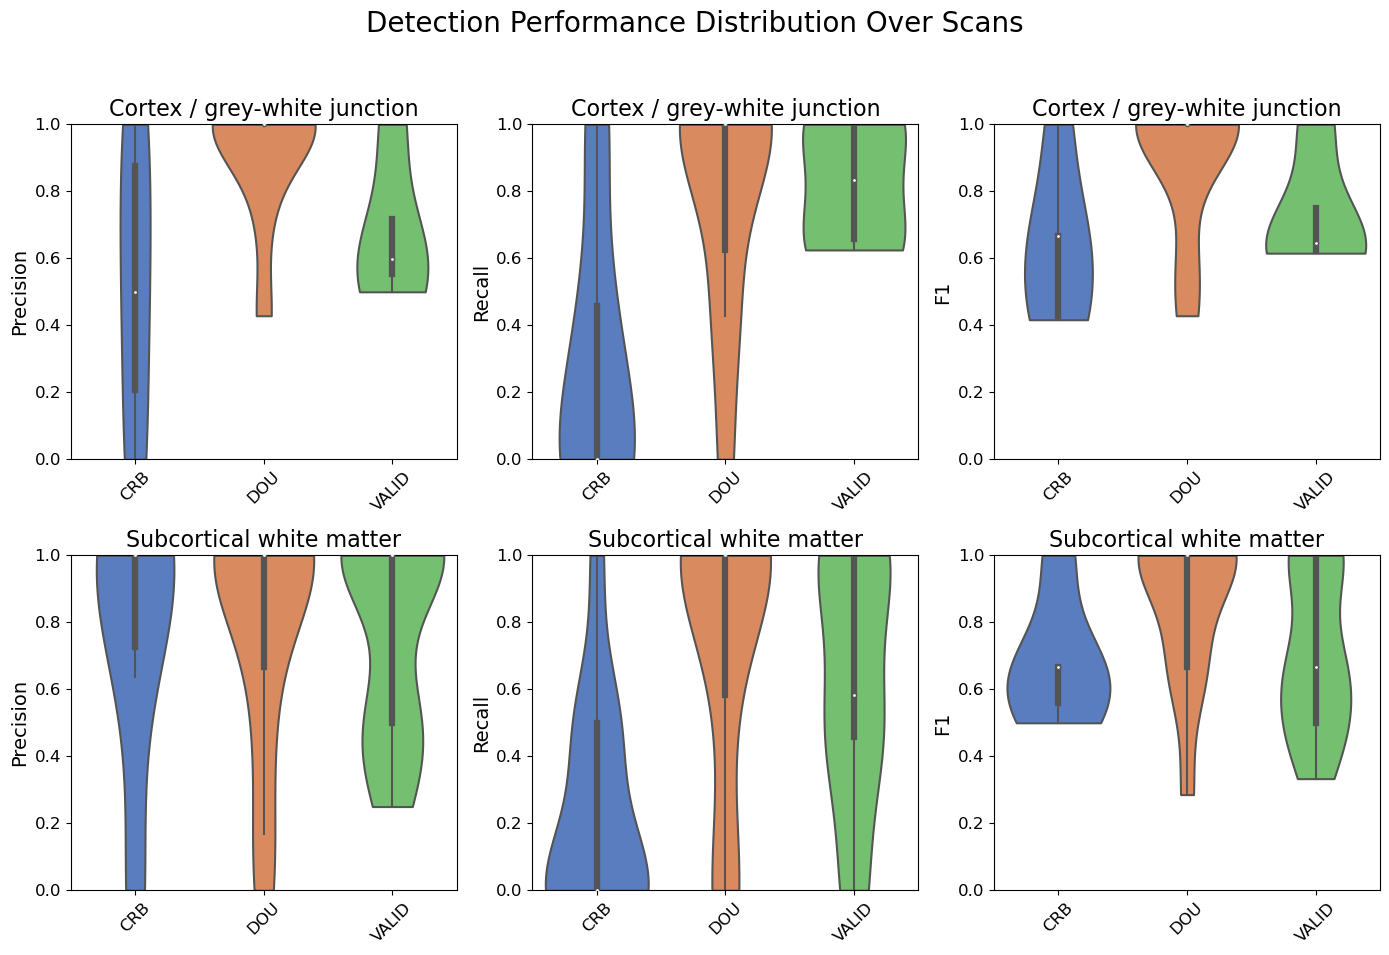

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
datasets = ["CRB", "DOU", "VALID"]
metrics = ["Precision", "Recall", "F1"]
locations = [
    "Cortex / grey-white junction",
    "Subcortical white matter",
    # "Basal ganglia grey matter",
    # "Thalamus",
    # "Brainstem"
]
model = "TL-Pretrained-FineTuned"

# Filter data for the specified model
df = data_cmb_df[data_cmb_df["Model"] == model]

# Setup figure and axes
fig, axs = plt.subplots(len(locations), len(metrics), figsize=(14,10))
fig.suptitle("Detection Performance Distribution Over Scans", fontsize=20)

# Prepare data to ensure all datasets appear in the plot
all_combinations = pd.DataFrame([(loc, ds, mt) for loc in locations for ds in datasets for mt in metrics], columns=['Location', 'Dataset', 'Metric'])
df = pd.merge(all_combinations, df, on=['Location', 'Dataset', 'Metric'], how='left')

# Iterate over locations and metrics to create a plot for each
for i, location in enumerate(locations):
    for j, metric in enumerate(metrics):
        # Filter the DataFrame for the current location and metric
        data_comb = df[(df["Location"] == location) & (df["Metric"] == metric)]


        utils_plotting.create_violin_plot(
            data=data_comb,
            column="Value",
            group_by="Dataset",
            ax=axs[i,j], 
            order=datasets,
            title=f"{location}",
            xlabel="",
            ylabel=metric.capitalize(),
            rotation=45,
            fontsize_title=16,
            fontsize_labels=14,
            fontsize_ticks=12,
            palette="muted",  # Adding color palette
            cut=0,  # Cut parameter for the KDE to limit it beyond the range of the data
            showfliers=True,
            showmeans=False,  # Optionally display the means
            inner="box",  # Show quartiles within the violin
            y_lim=[0,1],
        )
        
        # # Plotting the data
        # sns.violinplot(data=data_comb, x='Dataset', y='Value', ax=axs[i, j], order=datasets, palette="muted", cut=0, inner='box')
        # axs[i, j].set_title(f"{location}")
        # axs[i, j].set_xlabel('')
        # axs[i, j].set_ylabel(metric)

        # Check if data is completely empty and mark it as 'No Data'
        if data_comb['Value'].isna().all():
            axs[i, j].text(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', transform=axs[i, j].transAxes)
            axs[i, j].set_xlabel("Dataset")
            axs[i, j].set_ylabel("Value" if j == 0 else "")


# Adjust layout to accommodate the title and legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../../data-misc/img/detection_performance_by_location.png")
plt.show()


# Statistical Analysis

In [ ]:
# Define the list of columns to average
cols2average = [
    'shape_Elongation', 'shape_Flatness', 'shape_LeastAxisLength', 'shape_MajorAxisLength',
    'shape_Maximum2DDiameterColumn', 'shape_Maximum2DDiameterRow', 'shape_Maximum2DDiameterSlice',
    'shape_Maximum3DDiameter', 'shape_MeshVolume', 'shape_MinorAxisLength', 'shape_Sphericity',
    'shape_SurfaceArea', 'shape_SurfaceVolumeRatio', 'shape_VoxelVolume'
]

if all(col in GT_metadata_all.columns for col in cols2average + ['seriesUID']):
    GT_metadata_shape_averaged = GT_metadata_all.groupby('seriesUID')[cols2average].mean()

    # keep the 'seriesUID' in the resulting DataFrame as a column:
    GT_metadata_shape_averaged.reset_index(inplace=True)

else:
    print("One or more columns are missing in the DataFrame.")

In [ ]:
GT_metadata_shape_averaged

,seriesUID,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,shape_MeshVolume,shape_MinorAxisLength,shape_Sphericity,shape_SurfaceArea,shape_SurfaceVolumeRatio,shape_VoxelVolume
0,CRB-1.2.826.1.3680043.9.5282.150415.14832.1601...,0.407189,0.335430,2.128091,6.947582,7.255805,2.768069,7.320148,7.420816,23.609809,2.573052,0.732609,52.507282,2.496319,24.885417
1,CRB-1.2.826.1.3680043.9.5282.150415.178.178232...,0.568950,0.562332,3.878406,6.897007,7.158911,4.527693,7.382412,7.449832,69.453125,3.924050,0.800365,102.091695,1.469937,71.125000
2,CRB-1.2.826.1.3680043.9.5282.150415.24477.2447...,0.506075,0.496857,3.465689,6.976521,6.979823,4.265564,6.882465,7.193663,55.148438,3.530106,0.783664,89.520144,1.622376,56.687500
3,CRB-1.2.826.1.3680043.9.5282.150415.25794.2579...,0.303347,0.285929,1.980913,6.928442,6.184658,2.392789,6.254607,6.304635,19.164062,2.101440,0.773399,44.694905,2.343712,20.250000
4,CRB-1.2.826.1.3680043.9.5282.150415.34194.3419...,0.401419,0.374057,2.705514,7.248148,6.846874,3.328493,6.801250,6.983311,39.588542,2.903433,0.765543,70.186811,2.001287,40.881944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,VALDO-323-CMB-1,0.531117,0.379409,1.776391,4.681997,4.743416,2.549510,4.609772,4.847680,11.239583,2.486689,0.711570,34.100942,3.034004,12.125000
202,VALDO-324-CMB-1,0.448336,0.409668,2.719653,6.638681,6.500000,3.354102,6.708204,6.873864,28.807292,2.976362,0.704826,64.476859,2.238213,30.125000
203,VALDO-325-CMB-3,0.482751,0.377214,2.793345,7.432325,7.429988,4.025686,7.547480,7.973855,48.866319,3.418583,0.662355,90.546700,2.396970,50.416667
204,VALDO-326-CMB-1,0.561686,0.449359,2.457290,5.468434,6.324555,3.354102,6.324555,6.403124,19.630208,3.071542,0.692844,50.792401,2.587461,21.000000


In [ ]:
detection_details.keys()

dict_keys([('Scratch-Pretrained-FineTuned', 'valid', 'valloss', 'Cerebellum'), ('Scratch-Pretrained-FineTuned', 'valid', 'valloss', 'Thalamus'), ('Scratch-Pretrained-FineTuned', 'valid', 'valloss', 'Basal ganglia grey matter'), ('Scratch-Pretrained-FineTuned', 'valid', 'valloss', 'Brainstem'), ('Scratch-Pretrained-FineTuned', 'valid', 'valloss', 'Subcortical white matter'), ('Scratch-Pretrained-FineTuned', 'valid', 'valloss', 'Cortex / grey-white junction'), ('Scratch-Pretrained-FineTuned', 'dou', 'valloss', 'Thalamus'), ('Scratch-Pretrained-FineTuned', 'dou', 'valloss', 'Basal ganglia grey matter'), ('Scratch-Pretrained-FineTuned', 'dou', 'valloss', 'Brainstem'), ('Scratch-Pretrained-FineTuned', 'dou', 'valloss', 'Subcortical white matter'), ('Scratch-Pretrained-FineTuned', 'dou', 'valloss', 'Cortex / grey-white junction'), ('Scratch-Pretrained-FineTuned', 'crb', 'valloss', 'Cerebellum'), ('Scratch-Pretrained-FineTuned', 'crb', 'valloss', 'Thalamus'), ('Scratch-Pretrained-FineTuned', 

In [ ]:
import pandas as pd

# Define the model and criteria
model = 'TL-Pretrained-FineTuned'
criteria = 'valloss'

# List of datasets to process
datasets = ['dou', 'crb', 'valid']

# Initialize an empty list to store DataFrames
detections_results_perstudy_alldatasets = []

# Metrics to be extracted
metrics = ['Precision', 'Recall', 'F1']

# Loop over each dataset
for dataset in datasets:
    # Construct the key for the current dataset
    key = (model, dataset, criteria)

    # Check if the key exists in the detection details
    if key in detection_details:
        detection_details_comb = detection_details[key]
        
        # Build the DataFrame for the current dataset
        data = pd.DataFrame({
            "Dataset": [dataset.upper()] * len(detection_details_comb),
            "Model": [model] * len(detection_details_comb),
            "seriesUID": [s['seriesUID'] for s in detection_details_comb],
            **{metric: [s[metric] for s in detection_details_comb] for metric in metrics}
        })
        detections_results_perstudy_alldatasets.append(data)
    else:
        print(f"No data available for {key}.")

# Concatenate all DataFrame components into one DataFrame, if any exist
if detections_results_perstudy_alldatasets:
    detections_results_perstudy_alldatasets = pd.concat(detections_results_perstudy_alldatasets, ignore_index=True)
    print("Data concatenated successfully.")
else:
    print("No data to concatenate.")

# Optional: display or return the concatenated DataFrame
print(detections_results_perstudy_alldatasets.head())


No data available for ('TL-Pretrained-FineTuned', 'dou', 'valloss').
No data available for ('TL-Pretrained-FineTuned', 'crb', 'valloss').
No data available for ('TL-Pretrained-FineTuned', 'valid', 'valloss').
No data to concatenate.


AttributeError: 'list' object has no attribute 'head'

In [ ]:
# Initialize an empty list to store DataFrames
all_cmb_detections = []

# Iterate over the cmb_results dictionary
for key, results in cmb_results.items():
    model, dataset, criteria = key
    df = pd.DataFrame(results)
    df['Model'] = model
    df['Dataset'] = dataset
    df['Criteria'] = criteria
    all_cmb_detections.append(df)

# Concatenate all DataFrame components into one DataFrame, if any exist
if all_cmb_detections:
    cmb_calls_df = pd.concat(all_cmb_detections, ignore_index=True)
    print("Data concatenated successfully.")
    print(cmb_calls_df.head())
else:
    print("No data to concatenate.")

Data concatenated successfully.
            seriesUID               CM call  type       matched_CM  \
0  RODEJA-00001-CMB-2   (75, 226, 190)   FN    GT             None   
1  RODEJA-00001-CMB-2  (219, 205, 143)   FN    GT             None   
2  RODEJA-00008-CMB-1  (179, 110, 241)   FP  pred             None   
3  RODEJA-00008-CMB-1  (212, 247, 212)   TP  pred  (212, 247, 211)   
4  RODEJA-00008-CMB-1  (212, 247, 211)   TP    GT  (212, 247, 212)   

                          Model Dataset Criteria  
0  Scratch-Pretrained-FineTuned   valid  valloss  
1  Scratch-Pretrained-FineTuned   valid  valloss  
2  Scratch-Pretrained-FineTuned   valid  valloss  
3  Scratch-Pretrained-FineTuned   valid  valloss  
4  Scratch-Pretrained-FineTuned   valid  valloss  


In [ ]:
cmb_calls_df.shape

(1080, 8)

In [ ]:
cmb_calls_df['Dataset'].value_counts()

Dataset
valid    415
crb      378
dou      287
Name: count, dtype: int64

In [ ]:
cmb_calls_df

,seriesUID,CM,call,type,matched_CM,Model,Dataset,Criteria
0,RODEJA-00001-CMB-2,"(75, 226, 190)",FN,GT,None,Scratch-Pretrained-FineTuned,valid,valloss
1,RODEJA-00001-CMB-2,"(219, 205, 143)",FN,GT,None,Scratch-Pretrained-FineTuned,valid,valloss
2,RODEJA-00008-CMB-1,"(179, 110, 241)",FP,pred,None,Scratch-Pretrained-FineTuned,valid,valloss
3,RODEJA-00008-CMB-1,"(212, 247, 212)",TP,pred,"(212, 247, 211)",Scratch-Pretrained-FineTuned,valid,valloss
4,RODEJA-00008-CMB-1,"(212, 247, 211)",TP,GT,"(212, 247, 212)",Scratch-Pretrained-FineTuned,valid,valloss
...,...,...,...,...,...,...,...,...
1075,CRB-42a2a5865709f9ddc47da60a1556f09552586685-C...,"(191, 186, 162)",FN,GT,None,TL-Pretrained-FineTuned,crb,valloss
1076,CRB-42a2a5865709f9ddc47da60a1556f09552586685-C...,"(218, 208, 142)",FN,GT,None,TL-Pretrained-FineTuned,crb,valloss
1077,CRB-42a2a5865709f9ddc47da60a1556f09552586685-C...,"(222, 128, 179)",FN,GT,None,TL-Pretrained-FineTuned,crb,valloss
1078,CRB-42a2a5865709f9ddc47da60a1556f09552586685-C...,"(247, 186, 144)",FN,GT,None,TL-Pretrained-FineTuned,crb,valloss


In [ ]:
df_analysis  = pd.merge(detections_results_perstudy_alldatasets, GT_metadata_shape_averaged, on='seriesUID', how='inner')
print(df_analysis.shape,
      detections_results_perstudy_alldatasets.shape,
      GT_metadata_shape_averaged.shape)

(64, 20) (64, 6) (206, 15)


In [ ]:
df_analysis.columns

Index(['Dataset', 'Model', 'seriesUID', 'Precision', 'Recall', 'F1',
       'shape_Elongation', 'shape_Flatness', 'shape_LeastAxisLength',
       'shape_MajorAxisLength', 'shape_Maximum2DDiameterColumn',
       'shape_Maximum2DDiameterRow', 'shape_Maximum2DDiameterSlice',
       'shape_Maximum3DDiameter', 'shape_MeshVolume', 'shape_MinorAxisLength',
       'shape_Sphericity', 'shape_SurfaceArea', 'shape_SurfaceVolumeRatio',
       'shape_VoxelVolume'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
metrics = ['Precision', 'Recall', 'F1']
features = [
    'shape_Elongation', 'shape_Flatness', 'shape_LeastAxisLength', 
    'shape_MajorAxisLength', 'shape_Maximum2DDiameterColumn', 'shape_Maximum2DDiameterRow', 
    'shape_Maximum2DDiameterSlice', 'shape_Maximum3DDiameter', 'shape_MeshVolume', 
    'shape_MinorAxisLength', 'shape_Sphericity', 'shape_SurfaceArea', 
    'shape_SurfaceVolumeRatio', 'shape_VoxelVolume'
]

In [ ]:

correlation_results = []
df = df_analysis
for metric in metrics:
    for feature in features:
        df_analysis_temp = df_analysis[(~df_analysis[metric].isnull()) &  (~df_analysis[feature].isnull())]
        correlation, p_value = stats.pearsonr(df_analysis_temp[metric], df_analysis_temp[feature])
        correlation_results.append({
            'Metric': metric,
            'Feature': feature,
            'Correlation': correlation,
            'P-Value': p_value
        })
correlation_results_df = pd.DataFrame(correlation_results)

In [ ]:
correlation_results_df

,Metric,Feature,Correlation,P-Value
0,Precision,shape_Elongation,0.020092,0.885341
1,Precision,shape_Flatness,0.045995,0.741204
2,Precision,shape_LeastAxisLength,-0.104475,0.452154
3,Precision,shape_MajorAxisLength,-0.027521,0.843404
4,Precision,shape_Maximum2DDiameterColumn,-0.065051,0.640261
5,Precision,shape_Maximum2DDiameterRow,-0.098680,0.477756
6,Precision,shape_Maximum2DDiameterSlice,-0.039365,0.777472
7,Precision,shape_Maximum3DDiameter,-0.039618,0.776082
8,Precision,shape_MeshVolume,-0.231858,0.091601
9,Precision,shape_MinorAxisLength,-0.097584,0.482684


### CMB level

In [ ]:
df_analysis_cmb_gt  = pd.merge(cmb_calls_df, GT_metadata_all, on=['seriesUID', "CM"], how='inner')
print(df_analysis_cmb_gt.shape,
      cmb_calls_df.shape,
      GT_metadata_all.shape)

(646, 42) (1080, 8) (957, 36)


In [ ]:
df = df_analysis_cmb_gt
df['TP'] = (df['call'] == 'TP').astype(int)
df['FP'] = (df['call'] == 'FP').astype(int)
df['FN'] = (df['call'] == 'FN').astype(int)
df.drop_duplicates(subset=["seriesUID", "CM", "call"], keep='first', inplace=True)
df

,seriesUID,CM,call,type,matched_CM,Model,Dataset_x,Criteria,cmb_id,size,...,shape_MinorAxisLength,shape_Sphericity,shape_SurfaceArea,shape_SurfaceVolumeRatio,shape_VoxelVolume,count_dict,com_label,TP,FP,FN
0,RODEJA-00001-CMB-2,"(75, 226, 190)",FN,GT,None,Scratch-Pretrained-FineTuned,valid,valloss,0,5889,...,8.573826,0.733265,535.847765,0.731668,736.125,"{0.0: 33972369, 2.0: 516, 3.0: 4968, 24.0: 405}",24.0,0,0,1
2,RODEJA-00001-CMB-2,"(219, 205, 143)",FN,GT,None,Scratch-Pretrained-FineTuned,valid,valloss,1,15,...,0.930365,0.601802,9.272880,7.480642,1.875,"{0.0: 33978243, 41.0: 15}",41.0,0,0,1
4,RODEJA-00008-CMB-1,"(212, 247, 211)",TP,GT,"(212, 247, 212)",Scratch-Pretrained-FineTuned,valid,valloss,0,72,...,2.709736,0.698037,27.759933,3.460979,9.000,"{0.0: 44898390, 24.0: 17, 41.0: 34, 42.0: 21}",42.0,1,0,0
6,RODEJA-00051-CMB-3,"(223, 58, 95)",TP,pred,"(223, 58, 95)",Scratch-Pretrained-FineTuned,valid,valloss,1,157,...,2.162308,0.766965,44.146550,2.382946,19.625,"{0.0: 26080547, 24.0: 68, 41.0: 3, 42.0: 86}",24.0,1,0,0
10,RODEJA-00051-CMB-3,"(232, 124, 154)",TP,GT,"(232, 124, 153)",Scratch-Pretrained-FineTuned,valid,valloss,2,69,...,1.485773,0.645275,29.099576,3.803348,8.625,"{0.0: 26080635, 41.0: 62, 42.0: 7}",41.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,CRB-42a2a5865709f9ddc47da60a1556f09552586685-C...,"(191, 186, 162)",FN,GT,None,Scratch-Pretrained-FineTuned,crb,valloss,2,195,...,3.832389,0.782641,50.432666,2.162848,24.375,"{0.0: 33813675, 41.0: 29, 43.0: 10, 49.0: 128,...",49.0,0,0,1
638,CRB-42a2a5865709f9ddc47da60a1556f09552586685-C...,"(218, 208, 142)",FN,GT,None,Scratch-Pretrained-FineTuned,crb,valloss,3,94,...,2.757876,0.870887,27.430584,2.498421,11.750,"{0.0: 33813776, 51.0: 94}",51.0,0,0,1
640,CRB-42a2a5865709f9ddc47da60a1556f09552586685-C...,"(222, 128, 179)",FN,GT,None,Scratch-Pretrained-FineTuned,crb,valloss,4,245,...,3.877300,0.835184,55.502987,1.870231,30.625,"{0.0: 33813625, 24.0: 80, 42.0: 165}",24.0,0,0,1
642,CRB-42a2a5865709f9ddc47da60a1556f09552586685-C...,"(247, 186, 144)",FN,GT,None,Scratch-Pretrained-FineTuned,crb,valloss,5,788,...,5.031140,0.816139,124.985899,1.290177,98.500,"{0.0: 33813082, 24.0: 579, 42.0: 209}",24.0,0,0,1


In [ ]:
df[df["call"]=="FP"][["seriesUID", "CM", "call", "type" ,"TP", "FP", "FN", "matched_CM"]].sort_values(by=["seriesUID"])

,seriesUID,CM,call,type,TP,FP,FN,matched_CM


In [ ]:
import pandas as pd
import scipy.stats as stats

# Define your features
features = [
    'shape_Elongation', 'shape_Flatness', 'shape_LeastAxisLength', 
    'shape_MajorAxisLength', 'shape_Maximum2DDiameterColumn', 'shape_Maximum2DDiameterRow', 
    'shape_Maximum2DDiameterSlice', 'shape_Maximum3DDiameter', 'shape_MeshVolume', 
    'shape_MinorAxisLength', 'shape_Sphericity', 'shape_SurfaceArea', 
    'shape_SurfaceVolumeRatio', 'shape_VoxelVolume'
]

# Initialize a list to store correlation results
correlation_results = []

# Calculate point-biserial correlation for each dummy variable and each feature
for call_type in ['TP', 'FP', 'FN']:  # Iterate over each type of call
    for feature in features:
        # Filter out NaN values from both the call_type column and the feature column
        valid_data = df[[call_type, feature]].dropna()
        
        # Ensure there is enough data to compute the correlation
        if len(valid_data) > 1:
            correlation, p_value = stats.pointbiserialr(valid_data[call_type], valid_data[feature])
            correlation_results.append({
                'Call Type': call_type,
                'Feature': feature,
                'Correlation': correlation,
                'P-Value': p_value
            })
        else:
            correlation_results.append({
                'Call Type': call_type,
                'Feature': feature,
                'Correlation': np.nan,
                'P-Value': np.nan
            })

# Convert results to DataFrame for easier viewing and analysis
correlation_results_df = pd.DataFrame(correlation_results)
print(correlation_results_df)


   Call Type                        Feature  Correlation   P-Value
0         TP               shape_Elongation     0.107707  0.046230
1         TP                 shape_Flatness     0.104435  0.053312
2         TP          shape_LeastAxisLength    -0.107912  0.045816
3         TP          shape_MajorAxisLength    -0.199347  0.000203
4         TP  shape_Maximum2DDiameterColumn    -0.186074  0.000533
5         TP     shape_Maximum2DDiameterRow    -0.082664  0.126515
6         TP   shape_Maximum2DDiameterSlice    -0.177236  0.000979
7         TP        shape_Maximum3DDiameter    -0.180648  0.000776
8         TP               shape_MeshVolume    -0.139022  0.009942
9         TP          shape_MinorAxisLength    -0.119385  0.027044
10        TP               shape_Sphericity     0.070538  0.192495
11        TP              shape_SurfaceArea    -0.171237  0.001456
12        TP       shape_SurfaceVolumeRatio     0.053690  0.321474
13        TP              shape_VoxelVolume    -0.139649  0.00

/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/storage/evo1/jorge/anaconda

In [ ]:
correlation_results_df

,Call Type,Feature,Correlation,P-Value
0,TP,shape_Elongation,0.107707,0.046230
1,TP,shape_Flatness,0.104435,0.053312
2,TP,shape_LeastAxisLength,-0.107912,0.045816
3,TP,shape_MajorAxisLength,-0.199347,0.000203
4,TP,shape_Maximum2DDiameterColumn,-0.186074,0.000533
5,TP,shape_Maximum2DDiameterRow,-0.082664,0.126515
6,TP,shape_Maximum2DDiameterSlice,-0.177236,0.000979
7,TP,shape_Maximum3DDiameter,-0.180648,0.000776
8,TP,shape_MeshVolume,-0.139022,0.009942
9,TP,shape_MinorAxisLength,-0.119385,0.027044
